    7) 특성 자동선택
        - 새로운 특성 만드는 방법은 다양하다. 따라서 원본 특성 수 이상으로 증가하기 쉽다. 
        
           -> 과대적합, 모델 복잡의 원인이 된다. 
           
        - 새로운 특성 추가, 고차원 데이터 셋 이용시에는 가장 유용한 특성만 선택하고 나머지는 무시하는 것이 좋다. 
        
          (모델 간단, 일반화 성능 향상)
          
        - 일변량 통계, 모델 기반 선택, 반복적 선택으로 좋은 특성을 선택 할 수 있다. 
        - 이 3가지 방법은 모두 지도 학습 방법이므로 최적값을 찾으려면 타깃값이 필요하다. 
          
          ( 훈련, 테스트 셋으로 스필릿 후 훈련 데이터만 특성 선택에 이용해야 한다 )


            (1) 일변량 통계
                - 특성 간, 특성과 타깃 사이의 통계적 관계가 있는지 계산 후 깊게 연관된 특성 선택
                    ( 분산분석 이라고도 한다. )
                - 이 방법의 핵심 요소는 일변량(특성이 독립적으로 평가된다)
                - 타 특성과 깊게 연관된 특성은 선택 되지 않고, 계산이 매우 빨라 평가를 위한 모델 생성 X
                - 이 방식은 특성 선택 후 적용하려는 모델에 상관없이 사용 가능 
                - scikit-learn에서는 일변량 분석으로 특성 선택시 분류에서는 f_classif(기본)를 회귀에서는 f_regression을 보통 선택 후
                  테스트하고, 계산한 p-값에 기초하여 특성을 제외하는 방식 선택
                - 이 방식은 높은 p-값(타깃값과 연관성 작음)을 가진 특성 제외하도록 임계값 조정하는 매개변수 이용
                - 임계값 계산법은 다 다르며 가장 간단한 SelectKBest는 고정된 k개의 특성을 선택하고 SelectPercentile은 지정된 비율만큼 특성 선택
              
                  
                

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
import numpy as np

cancer = load_breast_cancer()

# 고정 난수 발생
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data),50))
#데이터에 노이즈 특성 추가

X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split ( X_w_noise, cancer.target, random_state = 0, test_size=.5)

#f_classif(디폴트)와 SelectPercentile 이용하여 특성의 50% 선택
select = SelectPercentile(score_func=f_classif, percentile = 50)
select.fit(X_train, y_train)

X_train_selected = select.transform(X_train)

print('X_train : ' , X_train.shape)
print('select : ', X_train_selected.shape)

X_train :  (284, 80)
select :  (284, 40)


특성 개수가 80개에서 40개로 줄은 것을 확인( 원본 특성의 50%)

get_support 매서드는 선택된 특성을 불리언 값으로 표시해 선택된 특성 확인가능

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


([<matplotlib.axis.YTick at 0x22d6cb91f48>],
 <a list of 1 Text yticklabel objects>)

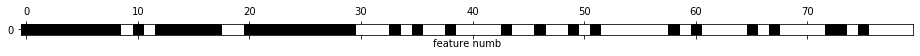

In [5]:
import matplotlib.pyplot as plt

mask = select.get_support()
print(mask)

#True 검정, Fasle 흰색

plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('feature numb')
plt.yticks([0])

대부분이 원본 특성에서 선택되었지만, 완벽하게 복원된 것이 아니다. 

In [6]:
#전체 특성 이용과, 선택 특성 이용시의 로지스틱 회귀 성능 비교

from sklearn.linear_model import LogisticRegression

X_test_selected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print('전체 이용 스코어', lr.score(X_test, y_test))

lr.fit(X_train_selected, y_train)
print('선택 이용 스코어', lr.score(X_test_selected, y_test))

전체 이용 스코어 0.9298245614035088
선택 이용 스코어 0.9403508771929825


c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


이 예제는 인위적이고 간단하게 만든 예제이고 실제 데이터에서는 엇갈리는 경우도 많다. 

하지만 많은 특성 때문에 모델 만들기가 현실적으로 어려울 때 일변량 분석을 이용한 피쳐 셀렉션이 도움이 된다. 

(많은 특성이 필요없다고 판단 될 시에도 )

        (2)모델 기반 특성 선택 
            - 지도학습 머신러닝 모델을 이용하여 특성의 중요도를 평가해 가장 중요한 특성들만 선택
            - 특성 선택에 이용하는 모델은 최종적으로 이용할 모델과 같을 필요는 없다. 
            - 특성 선택을 위한 모델은 각 특성의 중요도 순서를 매길 수 있어야 한다. 
            - 결정 트리와 이를 기반으로 한 모델은 각 특성의 중요도가 담긴 feature_importances_ 제공
            - 선형모델 계수의 절댓값도 특성의 중요도를 측정하는데 이용가능 
              ( L1 규제를 이용한 모델은 일부 특성의 계수만 학습한 것 확인 했었음 )
            - 일변량 분석과는 반대로 모델 기반은 한번에 모든 특성 고려하여 모델이 상호작용 잡아낸다면
              상호작용 부분 반영 가능 
            - 모델 기반 특성 선택은 SelectFromModel에 구현( 디폴트는 평균이며, 1.2*median, 1.3*mean과 같이 비율로 나타낼 수 있다)

In [7]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select = SelectFromModel( RandomForestClassifier(n_estimators = 100, random_state = 42), threshold='median')

SelectFromModel은 중요도가 지정된 임계치보다 큰 모든 특성을 선택

일변량 분석과 비교하기 위해 절반 가량이 선택 되도록 중간값을 임게치로 이용

트리 100개로 만들고 랜덤 포레스를 이용해 특성 중요도 계산 

In [8]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print('X_train ' , X_train.shape)
print('X_train_l1', X_train_l1.shape)

X_train  (284, 80)
X_train_l1 (284, 40)


Text(0.5, 0, 'feature numb')

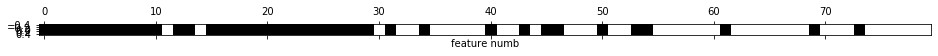

In [9]:
mask  = select.get_support()

plt.matshow(mask.reshape(1,-1),cmap = 'gray_r')
plt.xlabel('feature numb')

일변량 통계와는 달리 2개를 제외한 모든 원본 특성이 선택 되었다. 

노이즈는 40개의 특성을 선택하도록 지정하여 선택된것으로 보인다.

In [10]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print('score', score)

score 0.9508771929824561


c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


특성 선택이 잘되어 성능도 약 1퍼센트 향상 

        (3) 반복적 특성 선택 
            - 특성의 수가 각기 다른 일련의 모델 생성
               첫째, 특성을 하나도 선택하지 않는 상태로 시작해서 특정 종료 조건에 도달할 때 까지 하나씩 추가하는 방법
               둘째, 모든 특성을 가지고 시작해서 특정 종료 조건이 될 때까지 특성을 하나씩 제거해가는 방법 (재귀적 특성 제거)
            
            - 반복적인 계산으로 인해 시간이 많이 걸린다. 
            - 모델 기반 선택 처럼 특성 선택에 이용할 모델은 특성의 중요도를 결정하는 방법을 제공해야 한다.
              (예제는 랜덤포레스트 이용 )

Text(0.5, 0, 'feature numb')

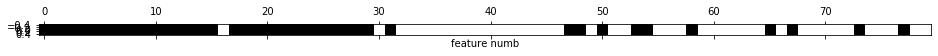

In [11]:
from sklearn.feature_selection import RFE

select = RFE(RandomForestClassifier(n_estimators=100, random_state = 42), n_features_to_select = 40)

select.fit(X_train, y_train)

#선택 특성 표시 
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('feature numb')

일변량 분석, 모델 기반 선택보다는 나아졌지만, 특성 한개를 놓쳤다.

반복 선택 모델은 말 그대로 반복진행으로 인해 시간비용이 크므로 이용시 시간적 여유를 고려해야한다.

In [12]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression().fit(X_train_rfe,y_train).score(X_test_rfe, y_test)

print('score', score)

score 0.9508771929824561


c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [13]:
#RFE의 경우 사용된 모델 이용해서 예측 가능 ( 이 경우 선택 특성만 이용 )
print('score', select.score(X_test, y_test))

score 0.9508771929824561


피쳐 셀렉션이 제대로 된다면, 선형 모델의 성능은 랜덤포레스트와 견줄만하다.

머신러닝 알고리즘에 어떤 입력값을 넣을지 확신이 안선다면 특성 자동 선택이 도움이 될 수 있고,

예측 속도 향상, 해석하기 쉬운 모델 생성에 도움이 된다. 